# Optimal Weather Derivative Hedge 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime as dt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from  InvarianceTestEllipsoid import InvarianceTestEllipsoid
from autocorrelation import autocorrelation
from scipy import stats
import scipy.signal as sig
import statsmodels.api as sm
from scipy.optimize import minimize

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
Tin = pd.read_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\Tout.pkl")

eta = pd.read_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\Tinnov.pkl")

Pin = pd.read_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\Pout.pkl")

Loss = pd.read_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\Loss.pkl")

dV = pd.read_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\dV.pkl")

V0 = pd.read_pickle("C:\\Users\\islipd\\Documents\\Thesis Notebooks\\V0.pkl")

-1067.504995273708

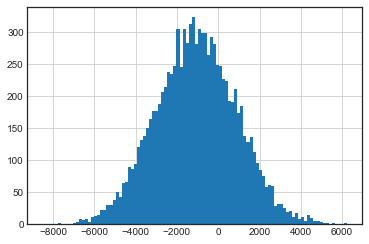

In [3]:
Loss.hist(bins=100);
Loss.mean()

### Too many constraints for daves laptop! See S. Alexander et al 

In [4]:
def rho(z):
    epsilon = 0.1
    if z>= epsilon:
        return z
    elif np.abs(z) < epsilon:
        return z**2/(4*epsilon) + 0.5*z + 0.25*epsilon
    else:
        return 0
    return -1

def Drho(z):
    epsilon = 0.1
    if z>= epsilon:
        return 1
    elif np.abs(z) < epsilon:
        return z/(2*epsilon) + 0.5
    else:
        return 0
    return -1
vrho = np.vectorize(rho)
vDrho = np.vectorize(Drho)

In [20]:
alpha = 1
x = np.random.rand(dV.shape[1]+1)
V0 = np.array(V0)
deltaV = np.array(dV)
Lss = np.array(Loss)
Beta = 0.95
omega = 10**(-4)
c = omega*np.percentile(Lss, 100*Beta)
C = 5000;
def F(x):
    return x[0] + (1/(1-Beta))*vrho(Lss - np.inner(deltaV,x[1:])-x[0]).mean() + c*abs(x[1:]).sum()
F(x)
def grad_F(x):
    der = np.zeros_like(x)
    der[0] = 1 - (1/(1-Beta))*vDrho(Lss - np.inner(deltaV,x[1:])-x[0]).mean()
    left = np.expand_dims((1/(1-Beta))*vDrho(Lss - np.inner(deltaV,x[1:])-x[0]),axis=0)
    M = left.size
    der[1:] = -1*(1/M)*np.inner(left,np.transpose(deltaV)) + c
    return der


In [21]:
cons = ({'type': 'ineq',
         'fun' : lambda x: -1*np.inner(V0,x[1:]) + C,
         'jac' : lambda x: -1*np.insert(V0,0,0)},
       {'type': 'ineq',
          'fun' : lambda x: -1*Lss.mean()+1*np.inner(deltaV, x[1:]).mean(),
          'jac' : lambda x: np.insert(1*deltaV.mean(axis = 0),0,0)})
bnds = ((None,None),)
for i in range(dV.shape[1]):
    bnds = bnds + ((0, C),)


In [22]:
res = minimize(F, x , jac=grad_F, bounds = bnds,
               constraints=cons, method='SLSQP', options={'disp': True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2833.015246927143
            Iterations: 55
            Function evaluations: 86
            Gradient evaluations: 55


In [7]:
dV.shape

(10000, 240)

Var without:2128.35273923
Var with:2060.42870667
% decrease:-0.0319138981573
Cost of portfolio:827.865656145


,0
0,"(2017-08-24 00:00:00, 91.0, -1.0, CDD, call)"
1,"(2017-08-24 00:00:00, 182.0, 0.0, Precip, call)"
2,"(2017-08-24 00:00:00, 182.0, 2.0, Precip, call)"
3,"(2017-11-23 00:00:00, 91.0, 0.0, HDD, call)"
4,"(2017-11-23 00:00:00, 91.0, 1.0, HDD, call)"
5,"(2017-11-23 00:00:00, 182.0, -1.0, HDD, call)"
6,"(2017-11-23 00:00:00, 182.0, 0.0, Precip, call)"
7,"(2017-11-23 00:00:00, 182.0, 1.0, HDD, call)"
8,"(2018-02-22 00:00:00, 91.0, 1.0, Precip, call)"
9,"(2018-02-22 00:00:00, 182.0, 0.0, CDD, call)"


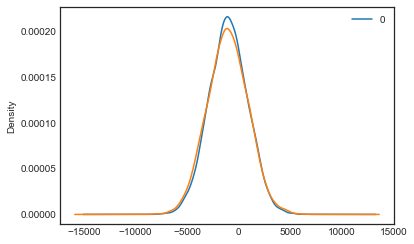

In [23]:
Lss_opt = Lss - np.inner(deltaV,res.x[1:])
plt.figure
pd.DataFrame(Lss_opt).plot.density()
Loss.plot.density()
print("Var without:" + str(np.percentile(Lss, 100*Beta)))
print("Var with:" + str(np.percentile(Lss_opt, 100*Beta)))
print("% decrease:" + str((np.percentile(Lss_opt, 100*Beta)-np.percentile(Lss, 100*Beta))/np.percentile(Lss, 100*Beta)))
print("Cost of portfolio:" + str(np.inner(V0,res.x[1:])))
weights = res.x[1:]/(res.x[1:].sum());
pd.DataFrame(dV.columns[weights > 0.01])

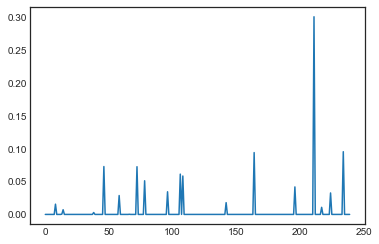

In [24]:
plt.figure
plt.plot(weights)